## Sample Sentiment Analysis
This notebook is a demo of sentiment analysis on a sample tweet data (50MB). We analysed the happy score (by labMIT happiness index) of tweets to discover:

### [Senario1] happiness score trend with no geo information
* The happiness trend from 2022.2 to 2022.8 (Can only be done with large dataset)
* The happiness score by hour 
* The happiness score by day of week

### [Senario2] happiness score trend with geo information
* The happiness score of Australia (as a baseline)
* The happiness score of states
* The happiness score of gcc & rural area
* The happiness socre of sal places

In [1]:
import json
import pandas as pd
from datetime import datetime
import nltk

import matplotlib.pyplot as plt
import geopandas as gpd
import folium

In [2]:
def tokenize_text(text):
    return nltk.word_tokenize(text)

# This function will calcuate the happi_socre using word frequency and the happy index from labMIT

def happi_score(df, index):
    all_tokens = sum(df['tokens'], [])

    # count word frequency
    word_freq = pd.Series(all_tokens).value_counts()
    word_freq.name = 'word_freq' 

    # merge text df with index df
    merged_df = pd.merge(index, word_freq, left_on='#word', right_index=True)

    # recount word frequency as some neutral data will be eliminated
    merged_df['word_freq'] = merged_df.word_freq/merged_df.word_freq.sum()
    result = (merged_df['happiness_average'] * merged_df['word_freq']).sum()
    #print(f'happiness score of {category} is: {result}')
    return result

def grouped_happi_score(df, group, index_df):
    lst = list(df[group].unique())
    df_token = df[['tokens',group]]
    df_grouped = df_token.groupby(group)['tokens'].sum().reset_index()

    happiness_scores = {}
    for each_group in lst:
        score = happi_score(df_grouped[df_grouped[group] == each_group], index_df)
        happiness_scores[each_group] = score
    return(happiness_scores)

In [3]:
path = '../data/raw/sample_tweets.json'

index0 = pd.read_csv('../data/raw/happiness_index/labMIT1.csv') #keep neutral words
index_df = index0.loc[(index0['happiness_average'] >= 5.5) | (index0['happiness_average'] <= 4.5)] #eliminate neutral words
index_df1 = index0.loc[(index0['happiness_average'] >= 6) | (index0['happiness_average'] <= 4)] #eliminate neutral words
index1 = index0.loc[(index0['happiness_average'] != 5)] #eliminate neutral words

In [5]:
f = open(path)
data = json.load(f)
extracted_data = []

for item in data:
    # check if the item has an "includes" field
    if "includes" in item["doc"]:
        # extract the tokens and place_id fields
        tokens = item["value"]["tokens"].lower().split("|")
        place = item["doc"]["includes"]["places"][0]["full_name"]
        time = item['doc']['data']['created_at']
        dt = datetime.fromisoformat(time[:-1])
        day_of_week = dt.weekday()
        year = dt.year
        month = dt.month
        date = dt.day
        hour = dt.hour
        text = item['doc']['data']["text"]
        sentiment = item['doc']['data']["sentiment"]    
        
        # append the extracted data as a tuple to the extracted_data list
        extracted_data.append((tokens, place, day_of_week, year, month, date, hour, sentiment, text))
        
# create a Pandas dataframe from the extracted data
df = pd.DataFrame(extracted_data, columns=["tokens", "full_name","dof", "year", "month", "date", "hour","sentiment", "text"])

In [6]:
df.to_csv('../data/raw/sample.csv')

In [7]:
df.head()

,tokens,full_name,dof,year,month,date,hour,sentiment,text
0,[swallows],"Sydney, New South Wales",3,2022,2,10,4,0.000000,@Felon82 He swallows
1,"[yup, zealots, work]","Sydney, New South Wales",3,2022,2,10,5,-0.400000,@marquelawyers Yup! Zealots at work.
2,[],"Darwin, Northern Territory",3,2022,2,10,0,0.000000,@marquelawyers https://t.co/BFqOUeu7Am
3,[],"Darwin, Northern Territory",3,2022,2,10,0,0.000000,@MoarToast https://t.co/aYJHMrca17
4,"[sinuses, are, close, upper, teeth, can, have,...","Nowra - Bomaderry, New South Wales",3,2022,2,10,0,-0.090909,@ArtistAffame My sinuses are so close to my up...


In [8]:
# some intuitive demo before we attach sal code

# Average happy score of AU
happi_score(df, index_df)

5.783068021734755

### Happiness socre distribution for every tweet

Eliminate neutral words (average happiness: 4.5 - 5.5)

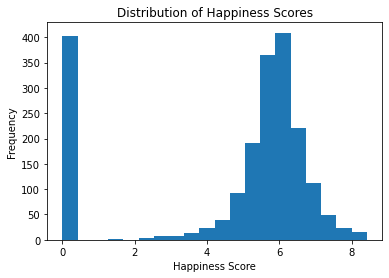

In [9]:
# create an empty list to store the scores
scores = []

# loop over the rows of the DataFrame
for index,row in df.iterrows():
    # calculate the happiness score for the row
    text = row['tokens']
    df_text = pd.DataFrame({'tokens': [text]})
    score = happi_score(df_text, index_df)
    # add the score to the list
    scores.append(score)

# create a histogram of the scores
plt.hist(scores, bins=20)
plt.xlabel('Happiness Score')
plt.ylabel('Frequency')
plt.title('Distribution of Happiness Scores')
plt.show()

Eliminate neutral words (average happiness: 4 - 6)

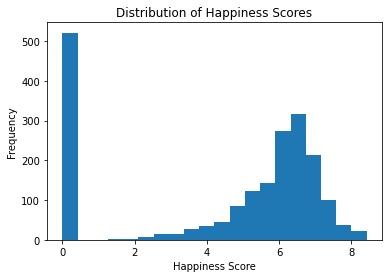

In [10]:
# create an empty list to store the scores
scores = []

# loop over the rows of the DataFrame
for index,row in df.iterrows():
    # calculate the happiness score for the row
    text = row['tokens']
    df_text = pd.DataFrame({'tokens': [text]})
    score = happi_score(df_text, index_df1)
    # add the score to the list
    scores.append(score)

# create a histogram of the scores
plt.hist(scores, bins=20)
plt.xlabel('Happiness Score')
plt.ylabel('Frequency')
plt.title('Distribution of Happiness Scores')
plt.show()

We will eliminate neutral words (average happiness: 4.5 - 5.5), as the histogram is more normal

### Sentiment score distribution

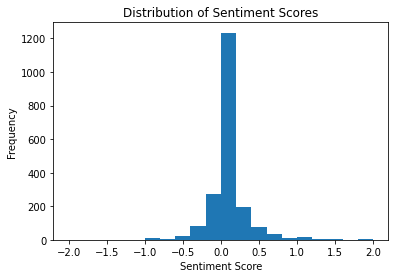

In [11]:
sentiment_lst = df['sentiment']
plt.hist(sentiment_lst, bins=20)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores')
plt.show()

### Happiness socre by hour

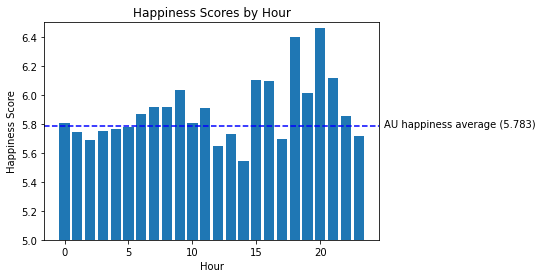

In [12]:
happiness_scores_hour = grouped_happi_score(df, 'hour', index_df)

plt.bar(happiness_scores_hour.keys(), happiness_scores_hour.values())
plt.xlabel('Hour')
plt.ylabel('Happiness Score')
plt.title('Happiness Scores by Hour')
plt.ylim(5, 6.5)  # set x-axis limits

# draw a horizontal line at y=5.783068021734755
au_avg = 5.783068021734755
plt.axhline(y=au_avg, color='blue', linestyle='--')
plt.text(25, 5.78, 'AU happiness average (5.783)')

plt.show()

Discovery the "Happy Hour"

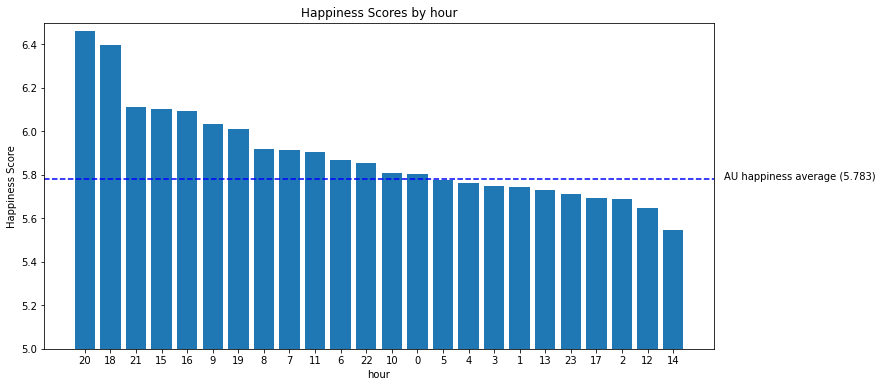

In [13]:
fig, ax = plt.subplots(figsize=(12,6))
happiness_scores_hour = {str(k): v for k, v in happiness_scores_hour.items()}
sorted_scores = dict(sorted(happiness_scores_hour.items(), key=lambda x: x[1], reverse=True))

ax.bar(sorted_scores.keys(), sorted_scores.values())

ax.set_xlabel('hour')
ax.set_ylabel('Happiness Score')
ax.set_title('Happiness Scores by hour')
ax.set_ylim(5, 6.5)  # set y-axis limits

# draw a horizontal line at y=5.783068021734755
au_avg = 5.783068021734755
ax.axhline(y=au_avg, color='blue', linestyle='--')
ax.text(len(ax.containers[0])+1, 5.78, 'AU happiness average (5.783)')

plt.show()

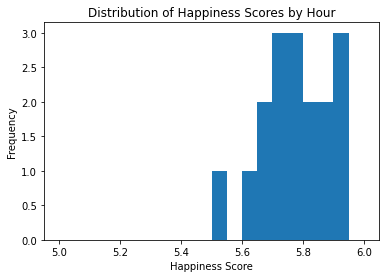

In [14]:
import matplotlib.pyplot as plt

# assuming the dictionary of scores is called `score_dict`
plt.hist(happiness_scores_hour.values(), bins=20, range=(5, 6))

plt.xlabel('Happiness Score')
plt.ylabel('Frequency')
plt.title('Distribution of Happiness Scores by Hour')

plt.show()

### Happiness socre by day of week

In [15]:

happiness_scores_hour = grouped_happi_score(df, 'dof', index_df)
happiness_scores_hour
# seems like we only have Wednesday data from sample. However, the analysis approach is similar

{3: 5.783068021734755}

## Senario 2
* The happiness score of Australia (as a baseline)
* The happiness score of states
* The happiness score of gcc & rural area
* The happiness socre of sal places

**Algorithm in Assignment1 was used to attach sal code (not perfect, just for demo)**

In [16]:
df2 = df 

In [17]:
twi_col = ['state_t', 'city_t']
df_col =['tokens', 'full_name', 'dof', 'year', 'month', 'date', 'hour', 'sentiment',
       'text']

def preprocess_twit(twit):
    # split full_name into city and state columns, and convert city to lowercase
    twit['city_t'] = twit['full_name'].str.split(', ').str[0].str.lower()
    twit['state'] = twit['full_name'].str.split(', ').str[1].str.lower()

    # clean city name by dropping suffix and part after " - "
    twit['city_t'] = twit['city_t'].str.split(' - ').str[0].str.lower() # if there is “ - ” in city, only keep the part before “ - ”
    twit['city_t'] = twit['city_t'].str.split('(').str[0].str.strip() # for city, drop state suffix

    # clean state name by dropping prefix and keeping state suffix
    twit['state'] = twit['state'].str.split('(').str[-1].str.strip() # for state, only keep state suffix
    twit['state'] = twit['state'].str.replace(r')', '', regex=False)
    twit = twit[['city_t','state']+df_col]
    state_abbrev = {'victoria': 'vic.', 'new south wales': 'nsw', 'queensland': 'qld', 'western australia': 'wa',
                  'south australia': 'sa', 'tasmania': 'tas.', 'northern territory': 'nt', 'australian capital territory': 'act'}
    twit['state_t'] = twit['state'].replace(state_abbrev)

    # keep only author_id, city_t, and state_t columns, and remove obvious outliers 
    # (eg. victoria, australia; austrlia etc.)
    obvi_outlier = ['australia', 'new south wales', 'victoria', 'queensland','western australia','south australia','northern territory','australian capital territory','tasmania']
    twit = twit[~twit.city_t.isin(obvi_outlier)] # drop obvi outliers 
    twit = twit[~twit.state_t.isin(['ontario', 'denver'])]
    twit = twit[['city_t','state_t']+df_col]
    return twit

# Preprocess sal.json
def preprocess_sal():
    # load raw data from JSON file and transpose
    sal = pd.read_json("../data/raw/sal.json")
    sal = sal.transpose()

    # reset index and rename columns
    sal.reset_index(inplace=True)
    sal.rename(columns={"index": "name"}, inplace=True)

    # extract city and state information
    sal['city'] = sal['name'].str.split(r' \(| - |\) ')
    sal['city'] = sal['city'].apply(lambda x: x[1] if len(x) == 3 else x[0])
    states_dict = {'1': 'nsw', '2': 'vic.', '3': 'qld', '4': 'sa', '5': 'wa', '6': 'tas.', '7': 'nt', '8': 'act', '9': 'oter'}
    sal.loc[(sal['ste'].isin(states_dict.keys())), 'state'] = sal.loc[(sal['ste'].isin(states_dict.keys())), 'ste'].map(states_dict)


    # keep only relevant columns and drop duplicates
    sal = sal[['gcc', 'sal', 'city', 'state']]
    sal.loc[sal[sal['sal'] == '31937'].index[0], ['city']] = 'mount archer'
    sal.loc[sal[sal['sal'] == '32621'].index[0], ['city']] = 'spring creek'
    sal = sal.drop_duplicates(subset=['state','city','gcc'])[['city', 'state','gcc','sal']]
    return sal

# direct match, city - city & state - state
def match_city_state(twit, gcc):
    # print(f'Step2: (Rank{rank}) In total {len(twit)}')
    df1= twit.merge(gcc, how='left', left_on = ['city_t', 'state_t'], right_on = ['city', 'state'],validate = "many_to_one")  # match the not-unique city
    df1_2 = df1[df1.gcc.notnull()]
    df1_unmatch = df1[df1.gcc.isnull()][twi_col]
    # print(f'Step2: (Rank{rank}) {len(df1_2)} ({round(len(df1_2)/len(twit)*100,2)}%) data matched')
    return df1_2, df1_unmatch

# match capital cities (city - city) | (state - city )
def match_capital_city(df, captial_gcc):

    df2 = df.merge(captial_gcc, how='left', left_on="state_t", right_on="city", validate = "many_to_one")  # state(twitter) - city(gcc) match
    df2_2 = df2[df2.gcc.notnull()]
    df2_unmatch = df2[df2.gcc.isnull()][twi_col]
    df3 = df2_unmatch.merge(captial_gcc, how='left', left_on="city_t", right_on="city", validate = "many_to_one") # city(twitter) - city(gcc) match
    df3_2 = df3[df3.gcc.notnull()]
    # print(f'Step2: (Rank{rank}) {len(df2_2)+ len(df3_2)} ({round((len(df2_2)+len(df3_2))/len(twit)*100,2)}%) data matched')
    return df2_2, df3_2

# merge tweets with gcc
def merge(twit, gcc, captial_gcc):

    df1, df1_unmatch = match_city_state(twit, gcc)
    df2, df3 = match_capital_city(df1_unmatch, captial_gcc)
    final = pd.concat([df1, df2, df3], ignore_index=True)
    # print(f'Step2: (Rank{rank}) In total {len(final)} ({round(len(final)/len(twit) *100,2)}%) data merged with gcc code')
    return final


In [18]:
# Process tweet data
twit = preprocess_twit(df2)

# Process gcc data
capital_city_gcc = ['1gsyd', '2gmel', '3gbri', '4gade', '5gper', '6ghob', '7gdar', '8acte', '9oter']
others = ["christmas island", "home island", "jervis bay", "norfolk island", "west island"]
capital_cities = ['canberra', 'sydney', 'darwin', 'brisbane', 'adelaide', 'hobart', 'melbourne', 'perth'] + others
gcc = preprocess_sal()
# captial_gcc = gcc.loc[(gcc.city.isin(capital_cities))&(gcc.gcc.isin(capital_city_gcc)), ['gcc', 'city','state']]
captial_gcc = gcc[gcc.gcc.isin(capital_city_gcc)][['gcc', 'city', 'state','sal']]
captial_gcc = captial_gcc[captial_gcc.city.isin(capital_cities)][['gcc', 'city', 'state','sal']]

# create merged parquet
final = merge(twit, gcc, captial_gcc)


<ipython-input-17-27452eacda22>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twit['state_t'] = twit['state'].replace(state_abbrev)


In [19]:
final.head()

,city_t,state_t,tokens,full_name,dof,year,month,date,hour,sentiment,text,city,state,gcc,sal
0,sydney,nsw,[swallows],"Sydney, New South Wales",3.0,2022.0,2.0,10.0,4.0,0.000000,@Felon82 He swallows,sydney,nsw,1gsyd,11215
1,sydney,nsw,"[yup, zealots, work]","Sydney, New South Wales",3.0,2022.0,2.0,10.0,5.0,-0.400000,@marquelawyers Yup! Zealots at work.,sydney,nsw,1gsyd,11215
2,darwin,nt,[],"Darwin, Northern Territory",3.0,2022.0,2.0,10.0,0.0,0.000000,@marquelawyers https://t.co/BFqOUeu7Am,darwin,nt,7gdar,70073
3,darwin,nt,[],"Darwin, Northern Territory",3.0,2022.0,2.0,10.0,0.0,0.000000,@MoarToast https://t.co/aYJHMrca17,darwin,nt,7gdar,70073
4,nowra,nsw,"[sinuses, are, close, upper, teeth, can, have,...","Nowra - Bomaderry, New South Wales",3.0,2022.0,2.0,10.0,0.0,-0.090909,@ArtistAffame My sinuses are so close to my up...,nowra,nsw,1rnsw,13039


### Happiness socre of AU

In [20]:
happi_score(df, index_df)

5.783068021734755

### Happiness socre by State

In [21]:
state_happiness_scores = grouped_happi_score(final, 'state', index_df)
sorted_scores = dict(sorted(state_happiness_scores.items(), key=lambda x: x[1], reverse=True))

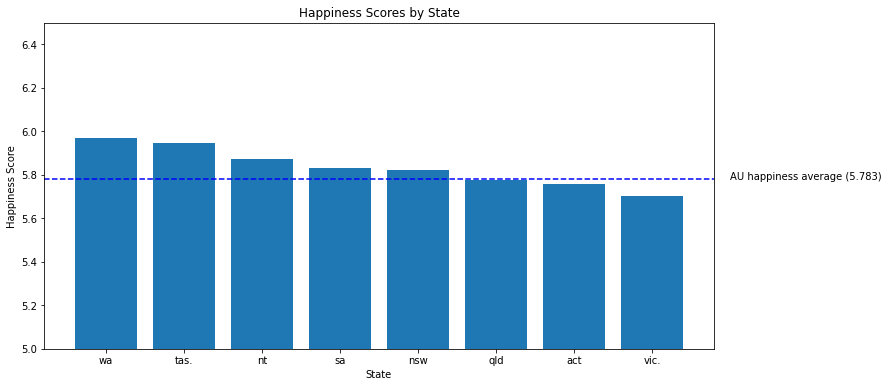

In [22]:
fig, ax = plt.subplots(figsize=(12,6))
plt.bar(sorted_scores.keys(), sorted_scores.values())

plt.xlabel('State')
plt.ylabel('Happiness Score')
plt.title('Happiness Scores by State')
plt.ylim(5, 6.5)  # set x-axis limits

# draw a horizontal line at y=5.783068021734755
au_avg = 5.783068021734755
plt.axhline(y=au_avg, color='blue', linestyle='--')
plt.text(len(ax.containers[0]), 5.78, 'AU happiness average (5.783)')

plt.show()

### Happiness socre by GCC

In [23]:
gcc_happiness_scores = grouped_happi_score(final, 'gcc', index_df)

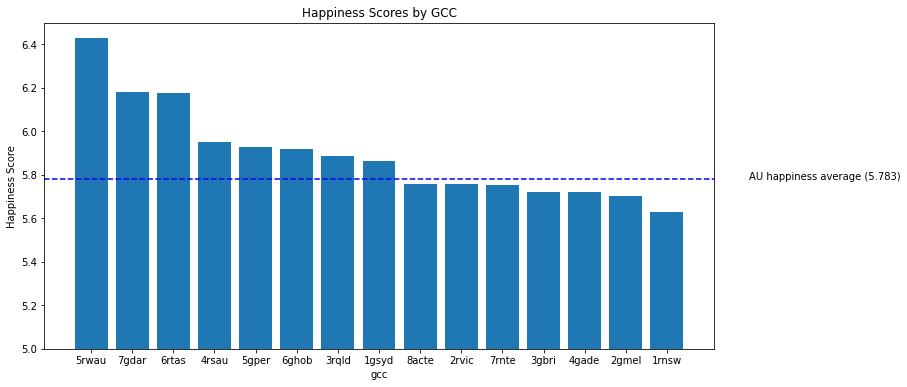

In [24]:
fig, ax = plt.subplots(figsize=(12,6))
sorted_scores = dict(sorted(gcc_happiness_scores.items(), key=lambda x: x[1], reverse=True))

ax.bar(sorted_scores.keys(), sorted_scores.values())

ax.set_xlabel('gcc')
ax.set_ylabel('Happiness Score')
ax.set_title('Happiness Scores by GCC')
ax.set_ylim(5, 6.5)  # set y-axis limits

# draw a horizontal line at y=5.783068021734755
au_avg = 5.783068021734755
ax.axhline(y=au_avg, color='blue', linestyle='--')
ax.text(len(ax.containers[0])+1, 5.78, 'AU happiness average (5.783)')

plt.show()

### Happiness distribution of sal

In [25]:
sal_happiness_scores = grouped_happi_score(final, 'sal', index_df)

In [26]:
sal_happiness_scores
df_sal = pd.DataFrame(list(sal_happiness_scores.items()), columns=['sal', 'score'])

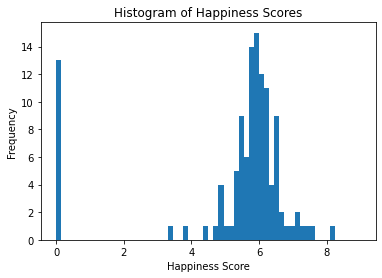

In [27]:
values =list(sal_happiness_scores.values())
plt.hist(values, bins=60, range=(0, 9))
plt.xlabel('Happiness Score')
plt.ylabel('Frequency')
plt.title('Histogram of Happiness Scores')
plt.show()

## Correlation Analysis
Analysis with SUDO data

In [32]:
gcc_happiness_scores = grouped_happi_score(final, 'gcc', index_df)
df_gcc = pd.DataFrame(list(gcc_happiness_scores.items()), columns=['gcc', 'score'])
df_gcc['gcc'] = df_gcc['gcc'].str.upper()
#df_gcc

In [34]:
median = pd.read_csv('../data/raw/sudo/abs_2021census.csv')
death_rate = pd.read_csv('../data/raw/sudo/abs_deaths_gccsa_2012_2020.csv')


In [35]:
df_cor = df_gcc.merge(median, how = "inner", left_on="gcc", right_on=" gccsa_code_2021").drop(columns=[" gccsa_code_2021"]).merge(death_rate[['gccsa_code', ' _2020_standardised_death_rate_rate']], left_on="gcc", right_on="gccsa_code").drop(columns=["gccsa_code"])
#df_cor.corr()

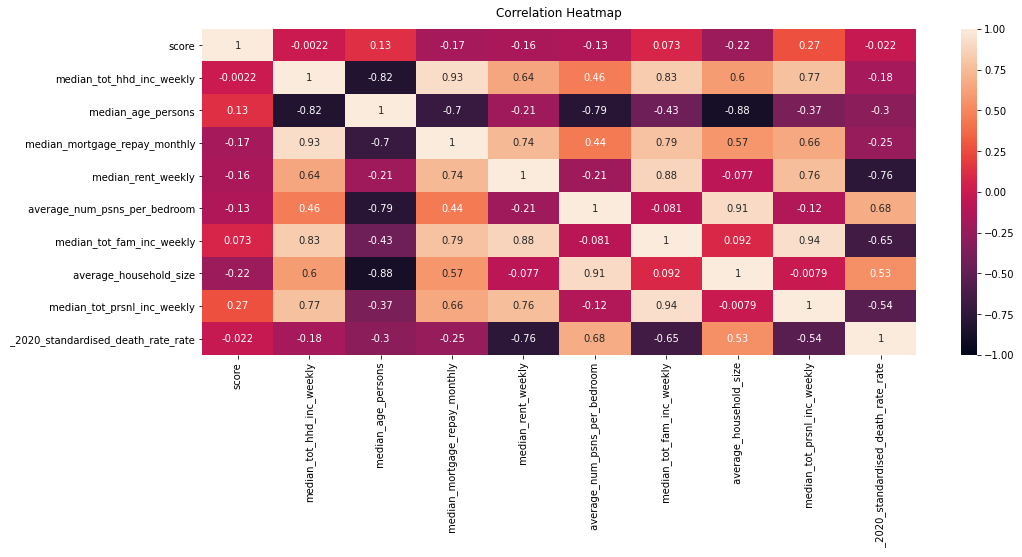

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#sns.heatmap(df_cor.corr())

# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_cor.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

## Geo Analysis
### Geo visual of Happiness Score of GCC


In [37]:
# get happinesss score for each gcc
gcc_happiness_scores = grouped_happi_score(final, 'gcc', index_df)
df_gcc = pd.DataFrame(list(gcc_happiness_scores.items()), columns=['gcc', 'score'])
df_gcc['gcc'] = df_gcc['gcc'].str.upper()


In [38]:
# read geo index data set 
gdf = gpd.read_file("../data/raw/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp")
geoboundary = gdf[['STE_CODE21','GCC_CODE21', 'geometry']].dropna()
geoJSON = geoboundary.to_json()

In [ ]:
# merge happiness socre dataset with geo index data set 
gdf2 = pd.merge(gdf, df_gcc, how='left', left_on='GCC_CODE21', right_on = 'gcc')

m = folium.Map(location=[-37.81, 144.96], tiles="Stamen Terrain", zoom_start=10, color='white')
svg_style = '<style>svg {background-color: rgb(255, 255, 255,0.5);}</style>'
m.get_root().header.add_child(folium.Element(svg_style))

c = folium.Choropleth(
    geo_data=geoJSON,
    name='choropleth',
    data=gdf2, 
    columns=['gcc','score'],
    key_on='properties.GCC_CODE21', 
    fill_color='Paired', 
    nan_fill_color='black',
    legend_name='happiness score per gcc area',
).add_to(m)

#m.save('../../plots/population_density_sa2.html')
m

### Geo Visual of Happiness Score of sal

In [40]:
# get happiness score for each sal
sal_happiness_scores = grouped_happi_score(final, 'sal', index_df)
df_sal = pd.DataFrame(list(sal_happiness_scores.items()), columns=['sal', 'score'])

In [41]:
gdf = gpd.read_file("../data/raw/SAL_2021_AUST_GDA2020_SHP/SAL_2021_AUST_GDA2020.shp")
geoboundary = gdf[['SAL_CODE21','STE_CODE21', 'STE_NAME21','geometry']].dropna()
geoJSON = geoboundary.to_json()

DriverError: ../data/raw/SAL_2021_AUST_GDA2020_SHP/SAL_2021_AUST_GDA2020.shp: No such file or directory

In [ ]:
# merge happiness socre dataset with geo index
gdf = pd.merge(geoboundary, df_sal, how='right', left_on='SAL_CODE21', right_on = 'sal')

In [ ]:
m = folium.Map(location=[-37.81, 144.96], tiles="Stamen Terrain", zoom_start=10, color='white')
svg_style = '<style>svg {background-color: rgb(255, 255, 255,0.5);}</style>'
m.get_root().header.add_child(folium.Element(svg_style))

c = folium.Choropleth(
    geo_data=geoJSON,
    name='choropleth',
    data=gdf, 
    columns=['sal','score'],
    key_on='properties.SAL_CODE21', 
    fill_color='Paired', 
    nan_fill_color='black',
    legend_name='happiness score per sal area',
).add_to(m)

#m.save('../../plots/population_density_sa2.html')
#m
 
# uncomment #m to see the map. It is a very large graph, plz clear the output after viewing

As we can see, the granularity of GCC is too big (refer to sample_geo_visual), whilst the granularity of SAL is too small (or maybe because the sample size is too small). Therefore, maybe we should consider using other granularities (such as SA2).